# Step #1 Load the Data

In [1]:
import pandas_datareader as webreader # Remote data access for pandas
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from keras.models import Sequential # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns

# Setting the timeframe for the data extraction
today = date.today()
date_today = today.strftime("%Y-%m-%d")
date_start = '2016-01-01'

stockname = 'BTC-USD'
# Getting BTC USD quotes
df = webreader.DataReader(
    'BTC-USD', start=date_start, end=date_today, data_source="yahoo"
)

# Create a quick overview of the dataset
train_dfs = df.copy()
train_dfs.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-01,436.246002,427.515015,430.721008,434.334015,36278900.0,434.334015
2016-01-02,436.062012,431.869995,434.622009,433.437988,30096600.0,433.437988
2016-01-03,433.743011,424.705994,433.578003,430.010986,39633800.0,430.010986
2016-01-04,434.516998,429.084015,430.061005,433.091003,38477500.0,433.091003
2016-01-05,434.182007,429.675995,433.069000,431.959991,34522600.0,431.959991


# Step #2 Exploring the Data

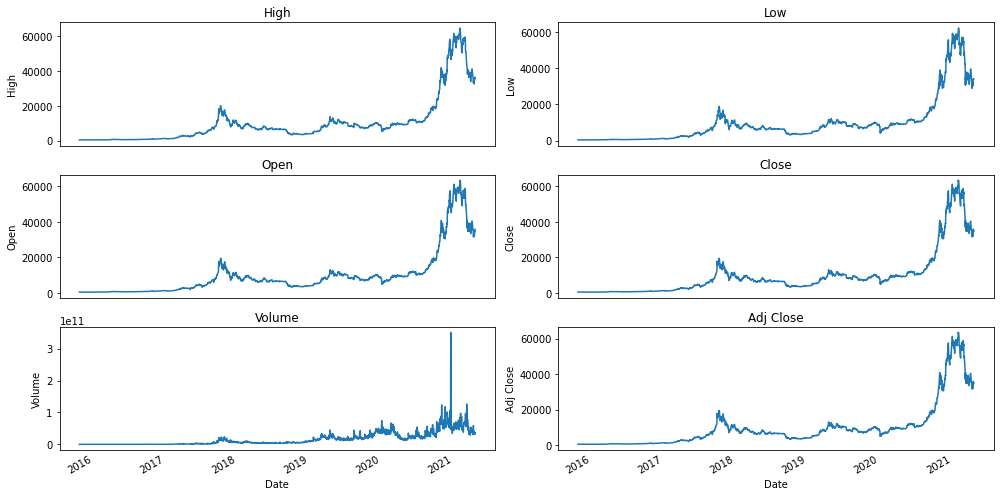

In [2]:
# Plot histograms
df_plot = train_dfs.copy()

list_length = df_plot.shape[1]
ncols = 2
nrows = int(round(list_length / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(0, list_length):
        ax = plt.subplot(nrows,ncols,i+1)
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.set_title(df_plot.columns[i])
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

# Step #3 Preprocessing and Feature Selection

In [3]:
# Indexing Batches
train_df = train_dfs.sort_values(by=['Date']).copy()

# We safe a copy of the dates index, before we need to reset it to numbers
date_index = train_df.index

# Adding Month and Year in separate columns
# d = pd.to_datetime(train_df.index)
# train_df['Month'] = d.strftime("%m")
# train_df['Year'] = d.strftime("%Y") 

# We reset the index, so we can convert the date-index to a number-index
train_df = train_df.reset_index(drop=True).copy()
train_df.head(5)

,High,Low,Open,Close,Volume,Adj Close
0,436.246002,427.515015,430.721008,434.334015,36278900.0,434.334015
1,436.062012,431.869995,434.622009,433.437988,30096600.0,433.437988
2,433.743011,424.705994,433.578003,430.010986,39633800.0,430.010986
3,434.516998,429.084015,430.061005,433.091003,38477500.0,433.091003
4,434.182007,429.675995,433.069000,431.959991,34522600.0,431.959991


In [4]:
# List of considered Features
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume'
            #, 'Month', 'Year', 'Adj Close'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

data_filtered.to_csv('btcUsdAllFOrScaler.csv')

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


,High,Low,Open,Close,Volume,Prediction
1999,32637.587891,30184.501953,31594.664062,32186.277344,3.858539e+10,32186.277344
2000,34656.128906,32071.757812,32287.523438,34649.644531,3.551164e+10,34649.644531
2001,35219.890625,33902.074219,34679.121094,34434.335938,3.389252e+10,34434.335938
2002,36542.109375,34252.484375,34475.558594,35867.777344,3.790146e+10,35867.777344
2003,36074.757812,34161.187500,35852.679688,34725.718750,3.242022e+10,34725.718750


In [5]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(2004, 5)


In [6]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50 # = number of neurons in the first layer of the neural network

# Prediction Index
index_Close = 0

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
test_data_len = math.ceil(np_data_scaled.shape[0] * 0.2) 

# Create the training and test data
test_data = np_data_scaled[0:test_data_len, :] 
train_data = np_data_scaled[test_data_len - sequence_length:, :]

# remove todays value
train_data = train_data[:-1]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(1602, 50, 5) (1602,)
(351, 50, 5) (351,)
0.01036903705727001
0.01036903705727001


# Step #4 Model Training

In [7]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

250 50 5


In [8]:
# Training the model
epochs = 50
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )

model.save("savedModel.tf")
                    
                    #callbacks=[early_stop])

Epoch 1/50
101/101 [==============================] - 26s 110ms/step - loss: 0.0164 - val_loss: 2.3145e-04
Epoch 2/50
101/101 [==============================] - 10s 99ms/step - loss: 6.8655e-04 - val_loss: 1.1325e-04
Epoch 3/50
101/101 [==============================] - 10s 97ms/step - loss: 4.7280e-04 - val_loss: 1.0983e-04
Epoch 4/50
101/101 [==============================] - 10s 98ms/step - loss: 3.6505e-04 - val_loss: 1.2081e-04
Epoch 5/50
101/101 [==============================] - 10s 97ms/step - loss: 5.8881e-04 - val_loss: 2.5495e-05
Epoch 6/50
101/101 [==============================] - 10s 96ms/step - loss: 3.0263e-04 - val_loss: 5.0738e-05
Epoch 7/50
101/101 [==============================] - 10s 99ms/step - loss: 3.4578e-04 - val_loss: 1.4948e-05
Epoch 8/50
101/101 [==============================] - 10s 96ms/step - loss: 2.7483e-04 - val_loss: 4.5049e-05
Epoch 9/50
101/101 [==============================] - 9s 91ms/step - loss: 2.7920e-04 - val_loss: 8.2831e-06
Epoch 10/50
10

INFO:tensorflow:Assets written to: savedModel.tf\assets


INFO:tensorflow:Assets written to: savedModel.tf\assets


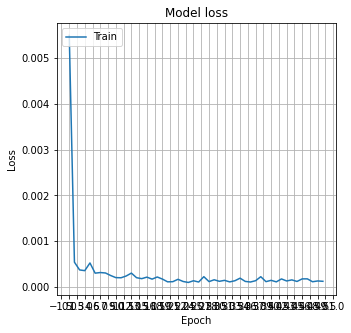

In [10]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(5, 5), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

# Step #5 Evaluate Model Performance

In [11]:
# Get the predicted values
y_pred = model.predict(x_test)

# Unscale the predicted values
y_pred_unscaled = scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred_unscaled)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred_unscaled)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 28.81
Mean Absolute Percentage Error (MAPE): 4.84 %
Median Absolute Percentage Error (MDAPE): 4.32 %


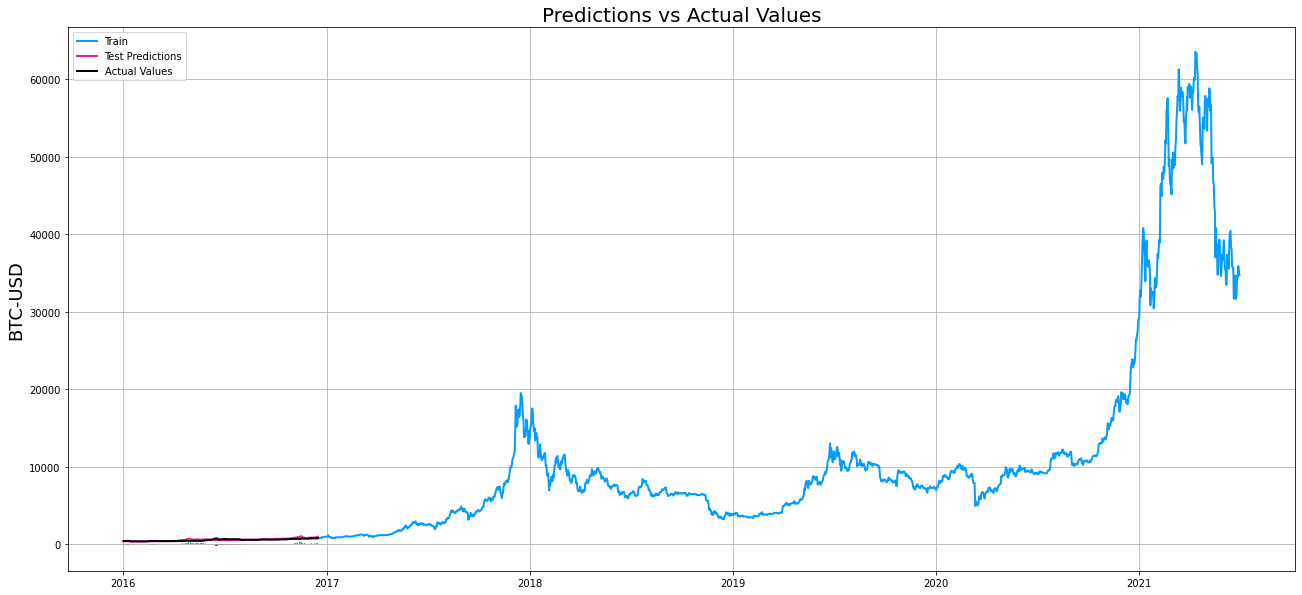

In [12]:
# The date from which on the date is displayed
display_start_date = date_start #pd.Timestamp('today') - timedelta(days=500)

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = date_index

# Add the difference between the valid and predicted prices
train = data_filtered_sub[test_data_len - sequence_length:]
valid = data_filtered_sub[:test_data_len - sequence_length]
valid.insert(1, "Prediction", y_pred_unscaled.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)

# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.ylabel('BTC-USD', fontsize=18)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

# Step #6 Predict Next Day's Price

In [13]:
# Get fresh data until today and create a new dataframe with only the price data
date_start = date.today() - timedelta(days=200)
date_yesterday = date.today() - timedelta(days=1)
new_df = webreader.DataReader(
    'BTC-USD', start=date_start, end=date_today, data_source="yahoo"
)

d = pd.to_datetime(new_df.index)
new_df['Month'] = d.strftime("%m") 
new_df['Year'] = d.strftime("%Y") 
new_df = new_df.filter(FEATURES)
new_df = new_df[:-1]

new_df.to_csv('btcUsd.csv')

# Get the last 100 day closing price values and scale the data to be values between 0 and 1
last_100_days = new_df[-100:].values
last_100_days_scaled = scaler.transform(last_100_days)

# Create an empty list and Append past 100 days
X_test_new = []
X_test_new.append(last_100_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled)

# Print last price and predicted price for the next day
price_yesterday = round(new_df['Close'][-1], 2)
predicted_price = round(pred_price_unscaled.ravel()[0], 2)
percent = round(100 - (predicted_price * 100)/price_yesterday, 2)

plus = '+'; minus = '-'
print(f'The close price for BTC-USD at {date_yesterday} was {price_yesterday}')
print(f'The predicted close price is {predicted_price} ({plus if percent > 0 else minus}{percent}%)')

The close price for BTC-USD at 2021-06-29 was 35867.78
The predicted close price is 36114.890625 (--0.69%)
